<a href="https://colab.research.google.com/github/San-lab-ship/clasificador-rese-as-peliculas/blob/main/clasificador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [1]:
from google.colab import files
import pandas as pd

print("Por favor, selecciona el archivo 'imdb_reviews.tsv' para subirlo.")
uploaded = files.upload()

for fn in uploaded.keys():
  file_name = fn

df_reviews = pd.read_csv(file_name, sep='\t', dtype={'votes': 'Int64'})

print(f"DataFrame '{file_name}' cargado exitosamente.")
print(df_reviews.head())

Por favor, selecciona el archivo 'imdb_reviews.tsv' para subirlo.


Saving imdb_reviews.tsv to imdb_reviews.tsv
DataFrame 'imdb_reviews.tsv' cargado exitosamente.
      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184  

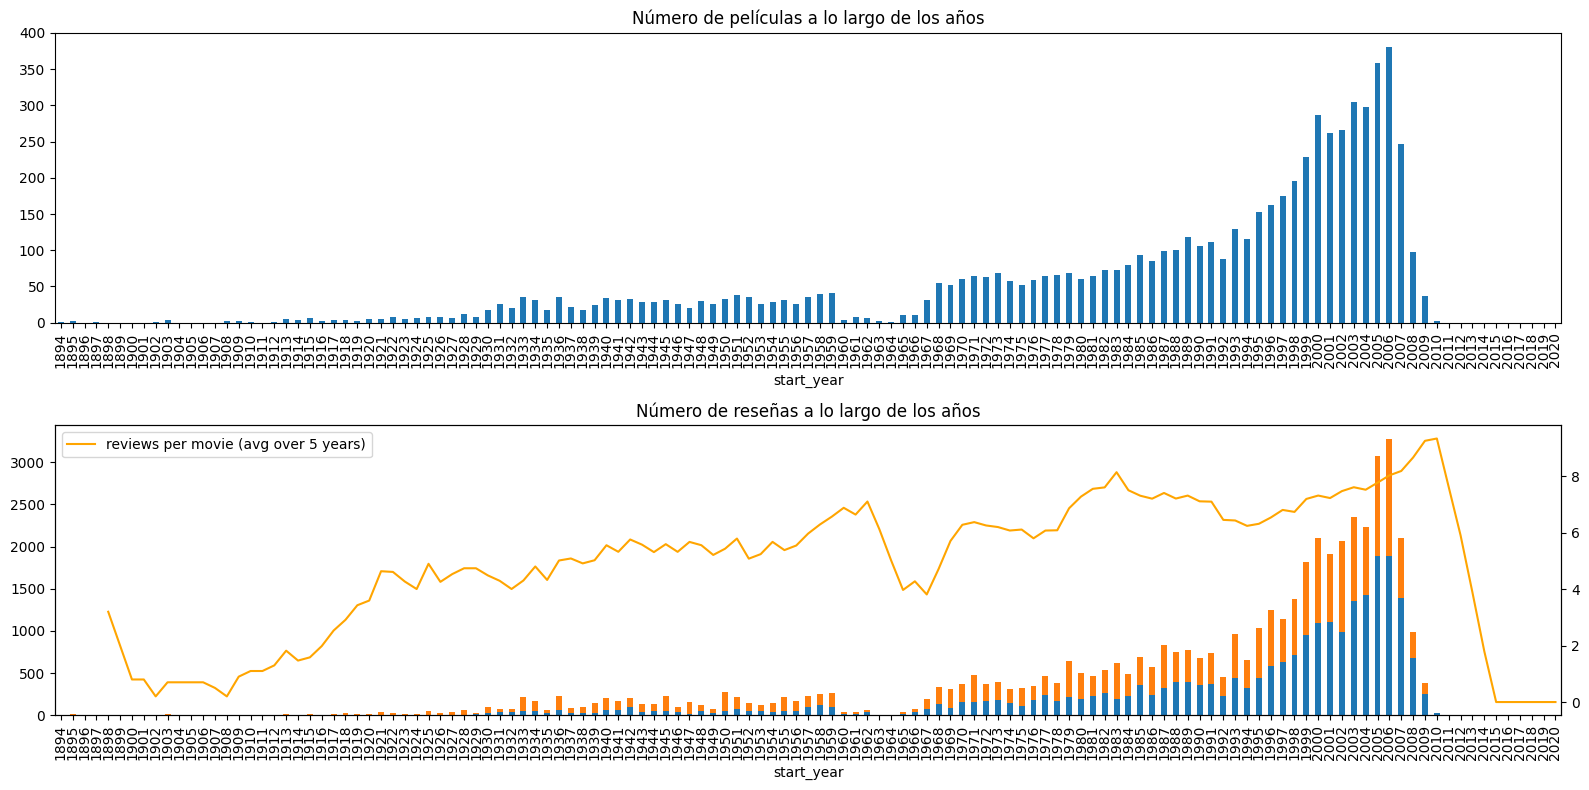

In [7]:
#EDA
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

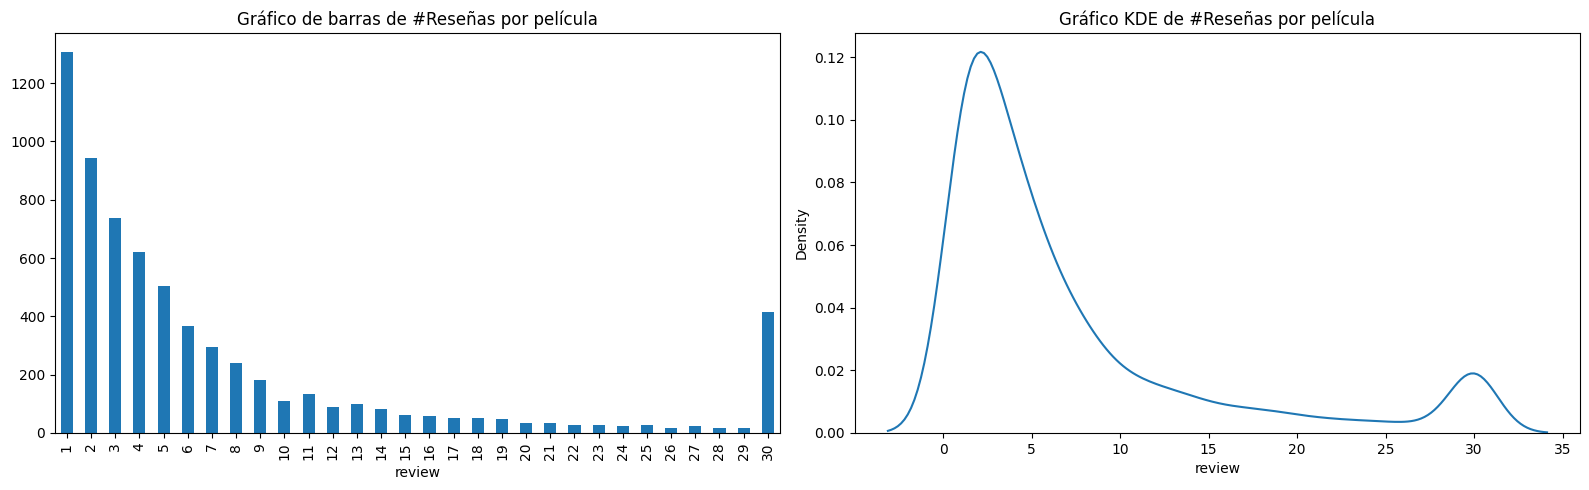

In [8]:
# distribución del número de reseñas por película con el conteo exacto y KDE
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [9]:
df_reviews['pos'].value_counts()

,count
pos,
0,23715
1,23616


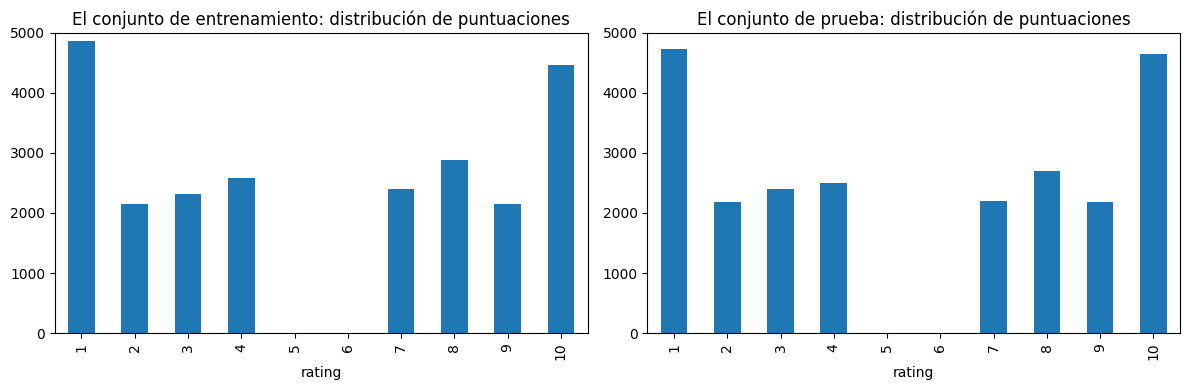

In [10]:
# Conjunto de Entrenamiento y Prueba
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

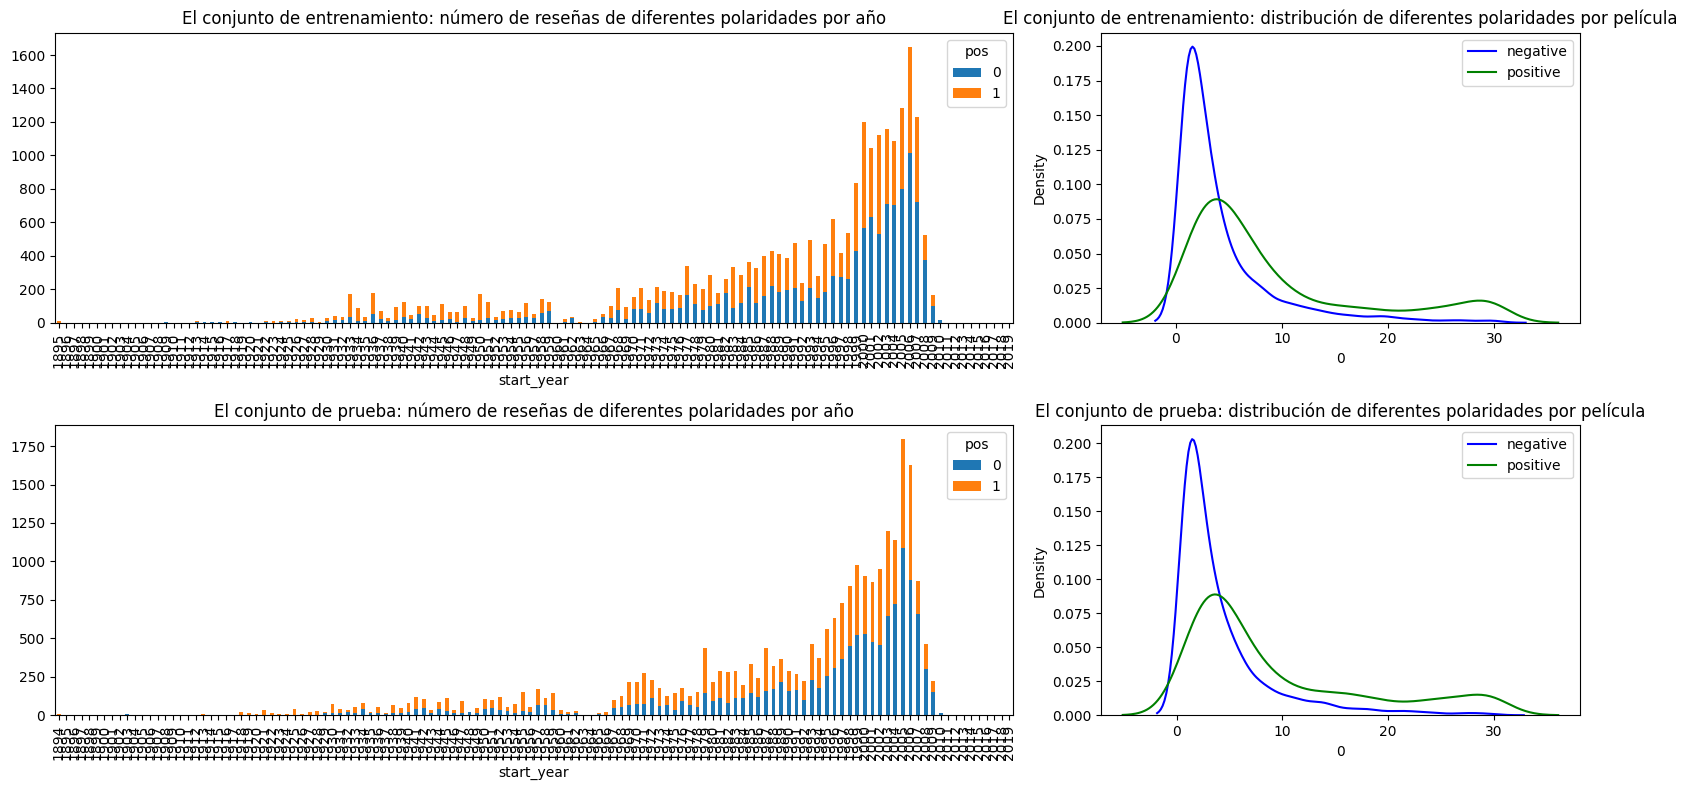

In [11]:
# Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd


fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]
dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]
dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()

sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]
dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]
dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()

sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()
plt.show()
plt.close(fig)